# gradient normalisation and momentum implementation



In [1]:
import networks
import numpy as np
from pathlib import Path
import pandas as pd
import matplotlib.pyplot as plt

np.random.seed(42)

In [11]:
def eval(layers, input, y, input_val = None, y_val = None, regularization_alpha=0, max_epochs = 100, batch_size = 32, learning_rate = 0.01, stochastic_descent = False, momentum = False, 
              momentum_decay = 0.9, rms_prop = False, squared_gradient_decay = 0.99, adam = False, epsilon=1e-8, early_stopping = False, min_stopping_delta = 1e-5, patience = 5, verbose=False, plot_losses = True,
              reruns = 5, norm = None):
        
        final_losses = []
        losses = {}
        
        for run in range(reruns):
            
            mlp = networks.MLP(layers, input = input,  regularization_alpha=regularization_alpha)
            
            temp_losses = mlp.train(input, y, input_val, y_val, max_epochs, batch_size, learning_rate, stochastic_descent, momentum, momentum_decay, rms_prop, squared_gradient_decay, adam, epsilon, early_stopping, min_stopping_delta, patience, verbose=False, plot_losses=False)
            losses[run] = np.array(temp_losses)
            y_hat = mlp.full_forward_pass(input_val)
                        
            y_hat_denorm = norm.denorm(y_hat.T, index="y").flatten()
            mse = np.mean((y_val.flatten() - y_hat_denorm) ** 2)
            
            final_losses.append(mse)
            print(f"Run {run+1} finished")
            
        final_losses = np.array(final_losses)
            
        print("Mean MSE:  {:.2f}±{:.2f}".format(final_losses.mean(), final_losses.std()))
        print("Min MSE: {:.2f}".format(final_losses.min()))
        print("Max MSE: {:.2f}".format(final_losses.max()))
        
        losses = pd.DataFrame(losses)
        plt.plot(losses.mean(axis=1))
        plt.fill_between(losses.index, losses.mean(axis=1) - losses.std(axis=1), losses.mean(axis=1) + losses.std(axis=1), alpha=0.2)
            
        return losses

In [3]:
# load datasets

data_dir = Path("data")
square_large_train = pd.read_csv(data_dir / "regression" / "square-large-training.csv", index_col=0)
square_large_test = pd.read_csv(data_dir / "regression" / "square-large-test.csv", index_col=0)
steps_large_train = pd.read_csv(data_dir / "regression" / "steps-large-training.csv", index_col=0)
steps_large_test = pd.read_csv(data_dir / "regression" / "steps-large-test.csv", index_col=0)
multimodal_large_train = pd.read_csv(data_dir / "regression" / "multimodal-large-training.csv")
multimodal_large_test = pd.read_csv(data_dir / "regression" / "multimodal-large-test.csv")


# square large train

In [4]:
layers = [
    {"output_dim": 30, "activation": "relu", "init": "he"},
    {"output_dim": 30, "activation": "relu", "init": "he"},
    {"activation": "linear", "init": "normal"}
]

mlp = networks.MLP(layers, input=square_large_train[["x"]].T)


In [5]:
norm = networks.assets.Normalizator(square_large_train)

square_large_train_norm = norm(square_large_train)
square_large_test_norm = norm(square_large_test)

In [6]:
max_epochs = 10000

In [12]:
eval(layers, square_large_train_norm[["x"]].T.to_numpy(), square_large_train_norm[["y"]].T.to_numpy(), square_large_test_norm[["x"]].T.to_numpy(), square_large_test[["y"]].T.to_numpy(), max_epochs=max_epochs, verbose=False, plot_losses=False, reruns=5, norm=norm,learning_rate=0.01, batch_size=256, momentum=True, momentum_decay=0.9)

Run 1 finished
Run 2 finished
Run 3 finished
Run 4 finished
Run 5 finished
Mean MSE:  78.11±23.67
Min MSE: 40.65
Max MSE: 104.02


ValueError: Per-column arrays must each be 1-dimensional

Epoch: 0, Loss: 10.54659274308991


Epoch: 100, Loss: 0.009570281454659327
Epoch: 200, Loss: 0.005250922229828476
Epoch: 300, Loss: 0.002931512696304722
Epoch: 400, Loss: 0.0019496694670872916
Epoch: 500, Loss: 0.0015482070568162709
Epoch: 600, Loss: 0.0013377028164193855
Epoch: 700, Loss: 0.0011604837784641123
Epoch: 800, Loss: 0.001048995754314871
Epoch: 900, Loss: 0.0009799136190421574
Epoch: 1000, Loss: 0.0009347658812348353
Epoch: 1100, Loss: 0.0008985996619253944
Epoch: 1200, Loss: 0.0008668064524505785
Epoch: 1300, Loss: 0.0008400417553850057
Epoch: 1400, Loss: 0.0008138174120831926
Epoch: 1500, Loss: 0.0007914663839977697
Epoch: 1600, Loss: 0.0007702626122819475
Epoch: 1700, Loss: 0.0007491449371680836
Epoch: 1800, Loss: 0.0007303361546264084
Epoch: 1900, Loss: 0.0007132831273421416
Epoch: 2000, Loss: 0.0006977533912976507
Epoch: 2100, Loss: 0.0006831243118716941
Epoch: 2200, Loss: 0.0006694047278200391
Epoch: 2300, Loss: 0.000655788962552806
Epoch: 2400, Loss: 0.0006420910141062179
Epoch: 2500, Loss: 0.000628025

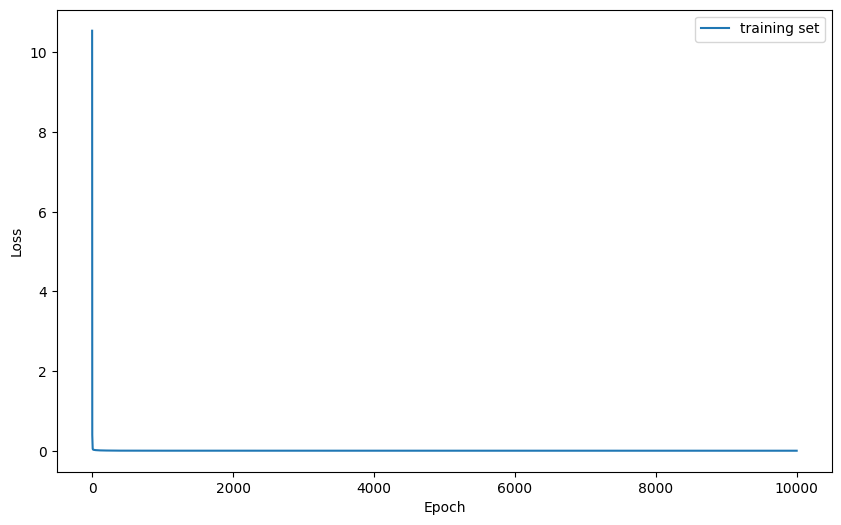

Text(0.5, 1.0, 'Loss of the model with momentum decay 0.9')

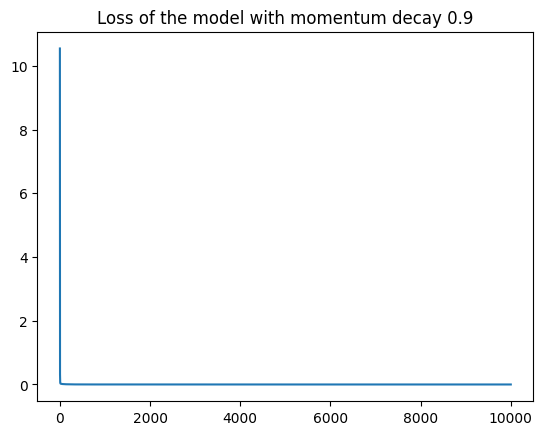

In [6]:
mlp = networks.MLP(layers, input=square_large_train_norm[["x"]].T)

losses = mlp.train(square_large_train_norm[["x"]].T.to_numpy(), square_large_train_norm[["y"]].T.to_numpy(), learning_rate=0.01, max_epochs=max_epochs, batch_size=256, momentum=True, momentum_decay=0.9)


plt.plot(losses)
plt.title("Loss of the model with momentum decay 0.9")

MSE: 1.9437944788326533


Text(0.5, 1.0, 'Prediction of the model with momentum decay 0.9, num of epochs: 10000')

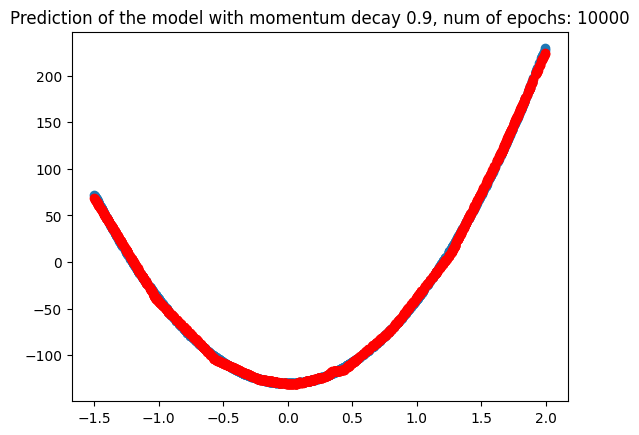

In [7]:
y_hat = mlp.full_forward_pass(square_large_train_norm[["x"]].T)

plt.scatter(square_large_train["x"], square_large_train["y"])
plt.scatter(square_large_train["x"], norm.denorm(y_hat.T, index="y"), color="red")

print("MSE:", np.mean((square_large_train["y"] - norm.denorm(y_hat.T, index="y").to_numpy().flatten())**2))
plt.title(f"Prediction of the model with momentum decay 0.9, num of epochs: {max_epochs}")

MSE: 70.29676381783264


Text(0.5, 1.0, 'Prediction of the model with momentum decay 0.9, num of epochs: 50000')

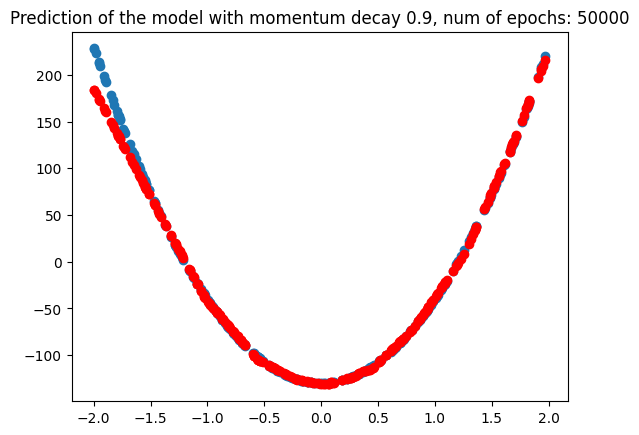

In [8]:
y_hat = mlp.full_forward_pass(square_large_test_norm[["x"]].T)

plt.scatter(square_large_test["x"], square_large_test["y"])
plt.scatter(square_large_test["x"], norm.denorm(y_hat.T, index="y"), color="red")

print("MSE:", np.mean((square_large_test["y"] - norm.denorm(y_hat.T, index="y").to_numpy().flatten())**2))
plt.title("Prediction of the model with momentum decay 0.9, num of epochs: 50000")

Epoch: 0, Loss: 3.5697531357414847
Epoch: 100, Loss: 0.03167108669776407
Epoch: 200, Loss: 0.02006930261650008
Epoch: 300, Loss: 0.01563699506454086
Epoch: 400, Loss: 0.01260684630936775
Epoch: 500, Loss: 0.010092895114734407
Epoch: 600, Loss: 0.00818040865024038
Epoch: 700, Loss: 0.006674713132094409
Epoch: 800, Loss: 0.005559304513869659
Epoch: 900, Loss: 0.004777205517310416
Epoch: 1000, Loss: 0.004164377683745574
Epoch: 1100, Loss: 0.0036534764024745083
Epoch: 1200, Loss: 0.0032161474409113573
Epoch: 1300, Loss: 0.002850371530325279
Epoch: 1400, Loss: 0.0025302822213378556
Epoch: 1500, Loss: 0.0022548558506414423
Epoch: 1600, Loss: 0.002022509847969436
Epoch: 1700, Loss: 0.0018204818281640333
Epoch: 1800, Loss: 0.0016470634009327462
Epoch: 1900, Loss: 0.001503137774809746
Epoch: 2000, Loss: 0.0013803549411906747
Epoch: 2100, Loss: 0.0012751757987481632
Epoch: 2200, Loss: 0.0011842593738568147
Epoch: 2300, Loss: 0.0011060842929128585
Epoch: 2400, Loss: 0.001035256207906052
Epoch: 25

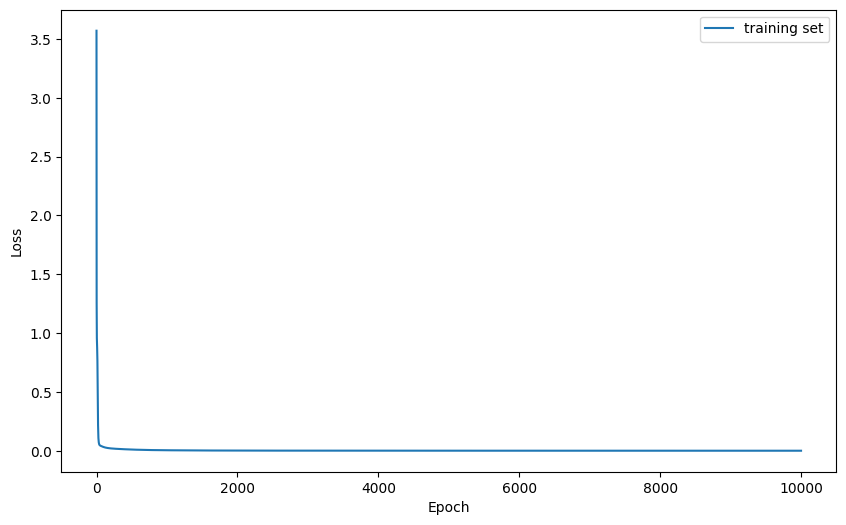

Text(0.5, 1.0, 'Loss of the model with squared gradient decay 0.9')

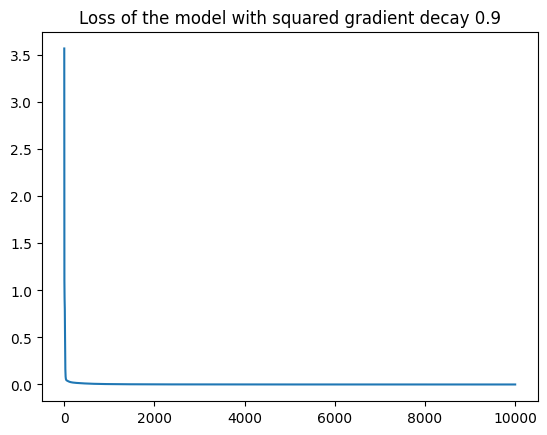

In [9]:
mlp = networks.MLP(layers, input=square_large_train_norm[["x"]].T)

losses = mlp.train(square_large_train_norm[["x"]].T.to_numpy(), square_large_train_norm[["y"]].T.to_numpy(), learning_rate=0.01, max_epochs=10000, batch_size=256, rms_prop=True, squared_gradient_decay=0.9)


plt.plot(losses)
plt.title("Loss of the model with squared gradient decay 0.9")

MSE: 62.99136440251373


Text(0.5, 1.0, 'Prediction of the model with squared gradient decay 0.9, num of epochs: 10000')

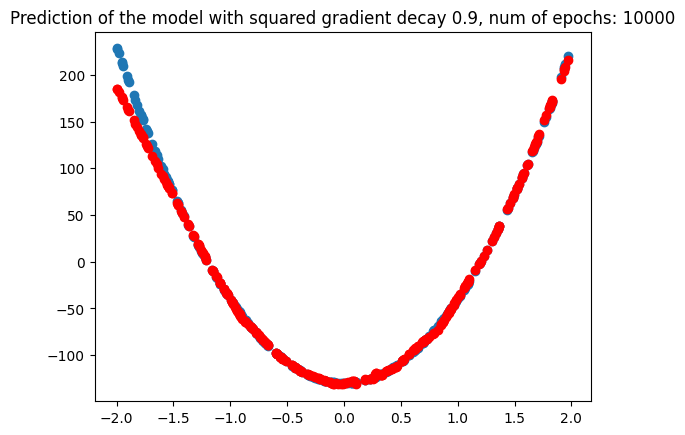

In [10]:
y_hat = mlp.full_forward_pass(square_large_test_norm[["x"]].T)

plt.scatter(square_large_test["x"], square_large_test["y"])
plt.scatter(square_large_test["x"], norm.denorm(y_hat.T, index="y"), color="red")

print("MSE:", np.mean((square_large_test["y"] - norm.denorm(y_hat.T, index="y").to_numpy().flatten())**2))
plt.title("Prediction of the model with squared gradient decay 0.9, num of epochs: 10000")

reshuffle

Text(0.5, 1.0, 'difference in shape of train and test data')

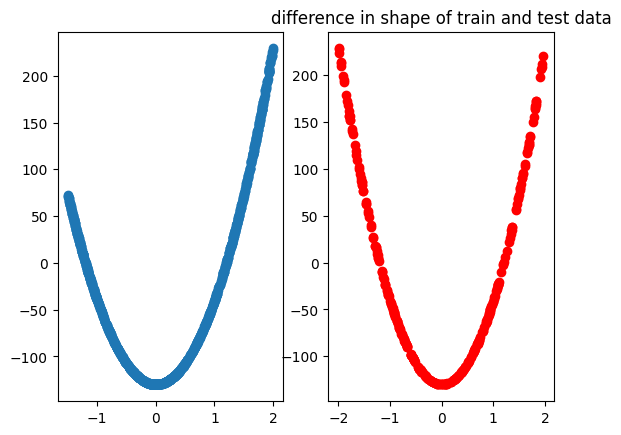

In [11]:
plt.subplot(1, 2, 1)
plt.scatter(square_large_train["x"], square_large_train["y"])
plt.subplot(1, 2, 2)
plt.scatter(square_large_test["x"], square_large_test["y"], c="red")
plt.title("difference in shape of train and test data")

In [36]:
from sklearn.model_selection import train_test_split

joined_square = pd.concat([square_large_train, square_large_test])


# Splitting the square_large dataset into train and test sets
square_large_train2, square_large_test2 = train_test_split(joined_square, test_size=0.2, random_state=42)

# Printing the shapes of the train and test sets
print("Train set shape:", square_large_train2.shape)
print("Test set shape:", square_large_test2.shape)

norm2 = networks.assets.Normalizator(square_large_train2)
square_large_test_norm2 = norm2(square_large_test2)
square_large_train_norm2 = norm2(square_large_train2)


Train set shape: (1040, 2)
Test set shape: (260, 2)


Epoch: 0, Loss: 0.4129940244631016


Epoch: 100, Loss: 0.02328460405815994
Epoch: 200, Loss: 0.007354725447276624
Epoch: 300, Loss: 0.0031443450728101327
Epoch: 400, Loss: 0.0021350517568511744
Epoch: 500, Loss: 0.0018403010592991358
Epoch: 600, Loss: 0.0018798592740003736
Epoch: 700, Loss: 0.001985990879185074
Epoch: 800, Loss: 0.0018383791047068866
Epoch: 900, Loss: 0.0017825460719885018
Epoch: 1000, Loss: 0.0018022598007482126
Epoch: 1100, Loss: 0.0011405464618757437
Epoch: 1200, Loss: 0.0009652663729020429
Epoch: 1300, Loss: 0.0008924857783394695
Epoch: 1400, Loss: 0.0008646290912779718
Epoch: 1500, Loss: 0.0004455300289755423
Epoch: 1600, Loss: 0.0003457349024654105
Epoch: 1700, Loss: 0.0002797019744993003
Epoch: 1800, Loss: 0.00023457719111957264
Epoch: 1900, Loss: 0.0002125687033991428
Epoch: 2000, Loss: 0.00019968866039974954
Epoch: 2100, Loss: 0.0001909954380169199
Epoch: 2200, Loss: 0.00018516320553535354
Epoch: 2300, Loss: 0.00018052489010014238
Epoch: 2400, Loss: 0.000176780320028496
Epoch: 2500, Loss: 0.00017

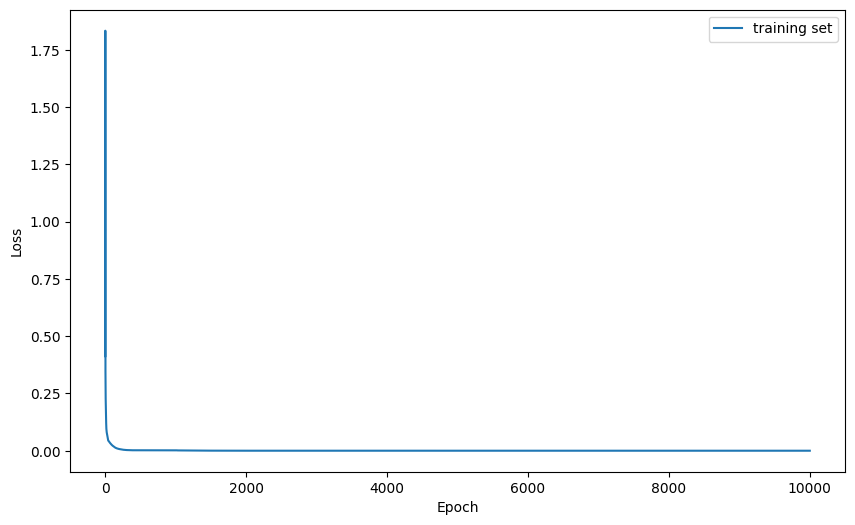

Training loss on the last epoch: 0.00014984511649872976


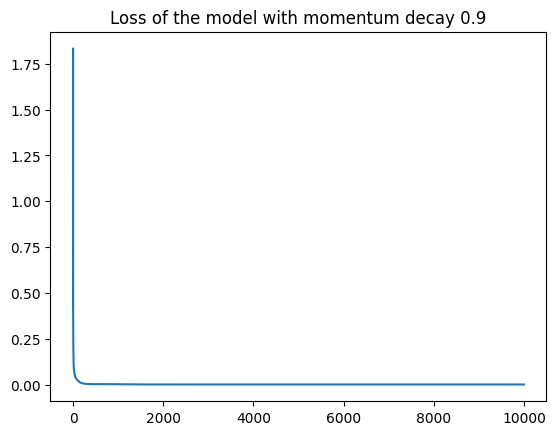

In [13]:
mlp = networks.MLP(layers, input=square_large_train_norm2[["x"]].T)

losses = mlp.train(square_large_train_norm2[["x"]].T.to_numpy(), square_large_train_norm2[["y"]].T.to_numpy(), learning_rate=0.025, max_epochs=max_epochs, batch_size=256, momentum=True, momentum_decay=0.9)


plt.plot(losses)
plt.title("Loss of the model with momentum decay 0.9")

print("Training loss on the last epoch:", losses[-1])

MSE: 1.4871228479730483


Text(0.5, 1.0, 'Prediction of the model with momentum decay 0.9, num of epochs: 10000 \n on randomlly split data')

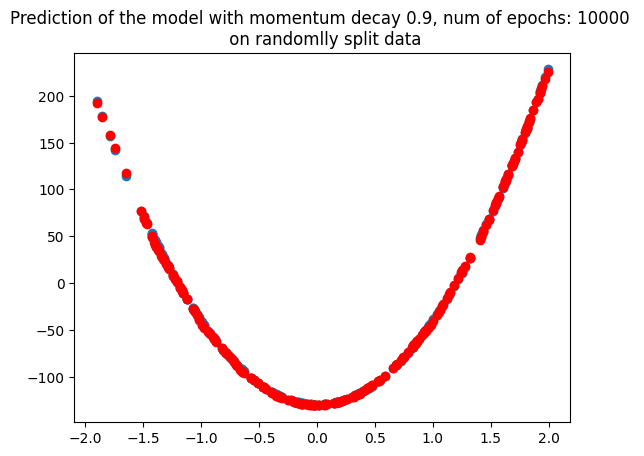

In [14]:
y_hat = mlp.full_forward_pass(square_large_test_norm2[["x"]].T)

plt.scatter(square_large_test2["x"], square_large_test2["y"])
plt.scatter(square_large_test2["x"], norm2.denorm(y_hat.T, index="y"), color="red")

print("MSE:", np.mean((square_large_test2["y"] - norm2.denorm(y_hat.T, index="y").to_numpy().flatten())**2))
plt.title(f"Prediction of the model with momentum decay 0.9, num of epochs: {max_epochs} \n on randomlly split data")

Epoch: 0, Loss: 0.9235901692659494


Epoch: 100, Loss: 0.012179892332573591
Epoch: 200, Loss: 0.005006853653175563
Epoch: 300, Loss: 0.001111909567257883
Epoch: 400, Loss: 0.0008210554933834166
Epoch: 500, Loss: 0.000688150249653245
Epoch: 600, Loss: 0.0005476600801755876
Epoch: 700, Loss: 0.0008734814426995722
Epoch: 800, Loss: 0.0004724754142057246
Epoch: 900, Loss: 0.0009734092762715044
Epoch: 1000, Loss: 0.0009591802512798064
Epoch: 1100, Loss: 0.0008339526594558954
Epoch: 1200, Loss: 0.0005652718575723902
Epoch: 1300, Loss: 0.0007071067029133564
Epoch: 1400, Loss: 0.0005870434394563382
Epoch: 1500, Loss: 0.000484998854407223
Epoch: 1600, Loss: 0.00039521340023341694
Epoch: 1700, Loss: 0.0002725555978421344
Epoch: 1800, Loss: 0.0002598558758598307
Epoch: 1900, Loss: 0.0002699564057279754
Epoch: 2000, Loss: 0.0003057745767896926
Epoch: 2100, Loss: 0.0003327263879986051
Epoch: 2200, Loss: 0.00039312842152921845
Epoch: 2300, Loss: 0.0003379215466983344
Epoch: 2400, Loss: 0.00022607426344820042
Epoch: 2500, Loss: 0.000210

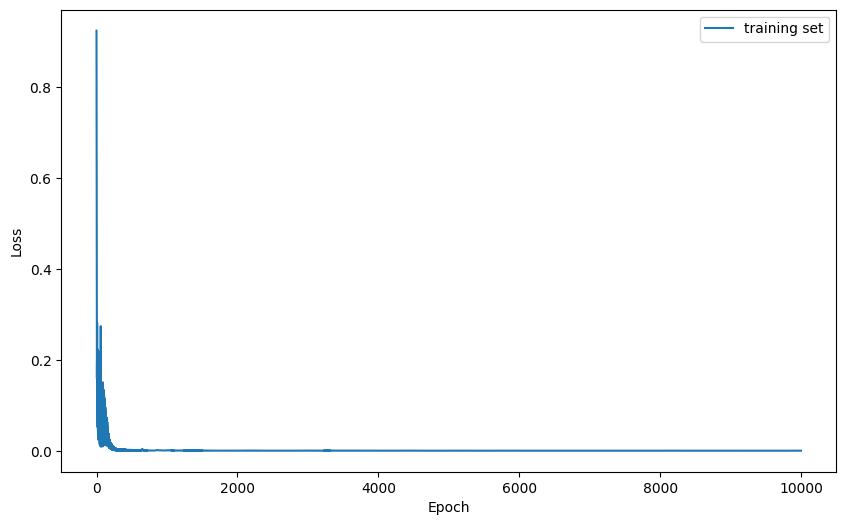

Text(0.5, 1.0, 'Loss of the model with momentum decay 0.9')

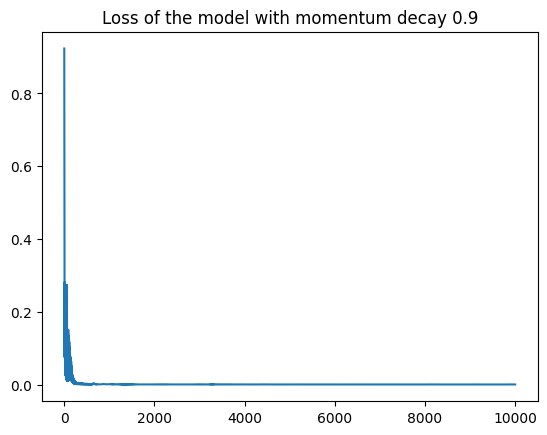

In [15]:
mlp = networks.MLP(layers, input=square_large_train_norm2[["x"]].T)

losses = mlp.train(square_large_train_norm2[["x"]].T.to_numpy(), square_large_train_norm2[["y"]].T.to_numpy(), learning_rate=0.025, max_epochs=max_epochs, batch_size=256, rms_prop=True, squared_gradient_decay=0.9)


plt.plot(losses)
plt.title("Loss of the model with momentum decay 0.9")

MSE: 1.5099987121438962


Text(0.5, 1.0, 'Prediction of the model with RMSprop with squared gradients decay 0.9,\n num of epochs: 10000 on randomlly split data')

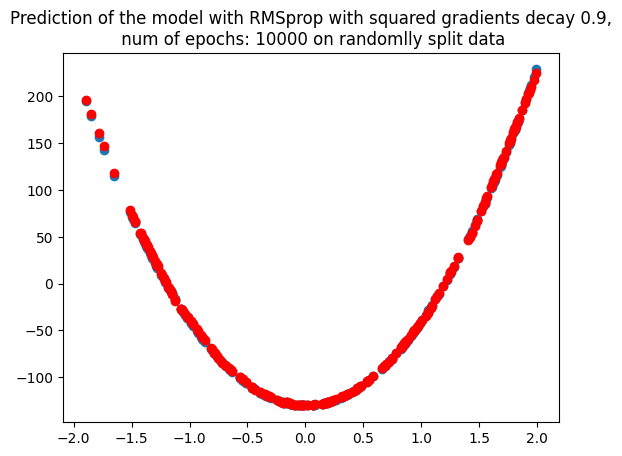

In [16]:
y_hat = mlp.full_forward_pass(square_large_test_norm2[["x"]].T)

plt.scatter(square_large_test2["x"], square_large_test2["y"])
plt.scatter(square_large_test2["x"], norm2.denorm(y_hat.T, index="y"), color="red")

print("MSE:", np.mean((square_large_test2["y"] - norm2.denorm(y_hat.T, index="y").to_numpy().flatten())**2))
plt.title(f"Prediction of the model with RMSprop with squared gradients decay 0.9,\n num of epochs: {max_epochs} on randomlly split data")

In [37]:
steps_large_train_norm = square_large_train_norm2
steps_large_test_norm = square_large_test_norm2
steps_large_train = square_large_train2
steps_large_test = square_large_test2
norm_steps = norm2

In [41]:
max_epochs = 100

Mean MSE:  7.88±3.54


Text(0.5, 1.0, 'Loss on square large, with RMSprop with squared gradients decay 0.9, num of epochs: 100')

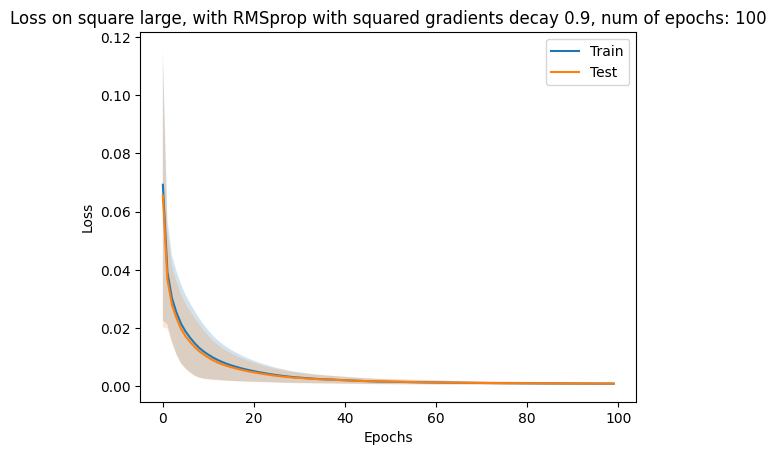

In [42]:
sum_losses = {}
sum_test_losses = {}
mses = []
momentum = 0.9
squred_gradient_decay = 0.9


for run in range(5):
    mlp_steps = networks.MLP(layers, input=steps_large_train_norm[["x"]].T, regularization_alpha=0)


    losses, test_losses = mlp_steps.train(steps_large_train_norm[["x"]].T.to_numpy(), steps_large_train_norm[["y"]].T.to_numpy(), steps_large_test_norm[["x"]].T.to_numpy(), steps_large_test_norm[["y"]].T.to_numpy(),
                         rms_prop=False, momentum=True, momentum_decay=momentum,
                            max_epochs=max_epochs, learning_rate = 0.02, batch_size=32, verbose=False, plot_losses=False, early_stopping=False)
    sum_losses[run] = losses
    sum_test_losses[run] = test_losses
    
    y_hat = mlp_steps.full_forward_pass(steps_large_test_norm[["x"]].T.to_numpy())

    mse = np.mean((steps_large_test["y"] - norm_steps.denorm(y_hat.T, index="y").flatten())**2)
    mses.append(mse)
    
    
sum_losses = pd.DataFrame(sum_losses)
sum_test_losses = pd.DataFrame(sum_test_losses)

print("Mean MSE:  {:.2f}±{:.2f}".format(np.mean(mses), np.std(mses)))

plt.plot(sum_losses.index, sum_losses.mean(axis=1), label="Train")
plt.fill_between(sum_losses.index, sum_losses.mean(axis=1) - sum_losses.std(axis=1), sum_losses.mean(axis=1) + sum_losses.std(axis=1), alpha=0.2)
plt.plot(sum_test_losses.index, sum_test_losses.mean(axis=1), label="Test")
plt.fill_between(sum_test_losses.index, sum_test_losses.mean(axis=1) - sum_test_losses.std(axis=1), sum_test_losses.mean(axis=1) + sum_test_losses.std(axis=1), alpha=0.2)
plt.legend()
plt.xlabel('Epochs')
plt.ylabel('Loss')

plt.title(f'Loss on square large, with RMSprop with squared gradients decay {squred_gradient_decay}, num of epochs: {max_epochs}')#with momentum, momentum decay {momentum}, num of epochs: {max_epochs}')

Mean MSE:  16.55±9.65


Text(0.5, 1.0, 'Loss on square large, with RMSprop with squared gradients decay 0.9, num of epochs: 100')

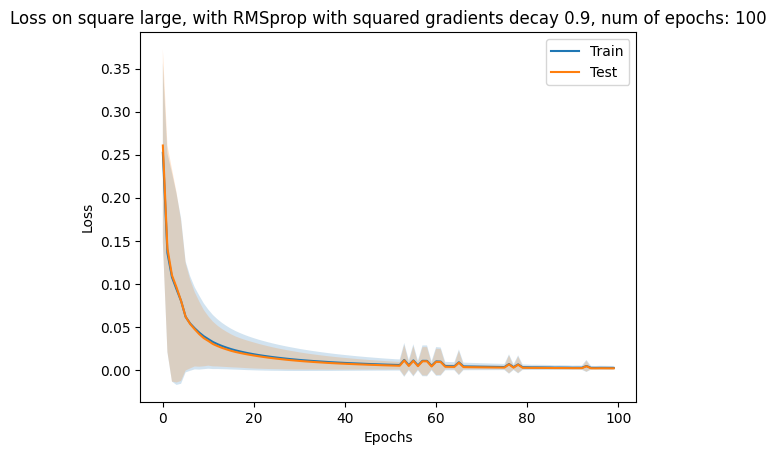

In [43]:
sum_losses = {}
sum_test_losses = {}
mses = []
momentum = 0.9
squred_gradient_decay = 0.9


for run in range(5):
    mlp_steps = networks.MLP(layers, input=steps_large_train_norm[["x"]].T, regularization_alpha=0)


    losses, test_losses = mlp_steps.train(steps_large_train_norm[["x"]].T.to_numpy(), steps_large_train_norm[["y"]].T.to_numpy(), steps_large_test_norm[["x"]].T.to_numpy(), steps_large_test_norm[["y"]].T.to_numpy(),
                         rms_prop=True, momentum=False, squared_gradient_decay=squred_gradient_decay,
                            max_epochs=max_epochs, learning_rate = 0.02, batch_size=32, verbose=False, plot_losses=False, early_stopping=False)
    sum_losses[run] = losses
    sum_test_losses[run] = test_losses
    
    y_hat = mlp_steps.full_forward_pass(steps_large_test_norm[["x"]].T.to_numpy())

    mse = np.mean((steps_large_test["y"] - norm_steps.denorm(y_hat.T, index="y").flatten())**2)
    mses.append(mse)
    
    
sum_losses = pd.DataFrame(sum_losses)
sum_test_losses = pd.DataFrame(sum_test_losses)

print("Mean MSE:  {:.2f}±{:.2f}".format(np.mean(mses), np.std(mses)))

plt.plot(sum_losses.index, sum_losses.mean(axis=1), label="Train")
plt.fill_between(sum_losses.index, sum_losses.mean(axis=1) - sum_losses.std(axis=1), sum_losses.mean(axis=1) + sum_losses.std(axis=1), alpha=0.2)
plt.plot(sum_test_losses.index, sum_test_losses.mean(axis=1), label="Test")
plt.fill_between(sum_test_losses.index, sum_test_losses.mean(axis=1) - sum_test_losses.std(axis=1), sum_test_losses.mean(axis=1) + sum_test_losses.std(axis=1), alpha=0.2)
plt.legend()
plt.xlabel('Epochs')
plt.ylabel('Loss')

plt.title(f'Loss on square large, with RMSprop with squared gradients decay {squred_gradient_decay}, num of epochs: {max_epochs}')

Mean MSE:  9.32±2.38


Text(0.5, 1.0, 'Loss on square large, without RMSprop nor momentum, num of epochs: 100')

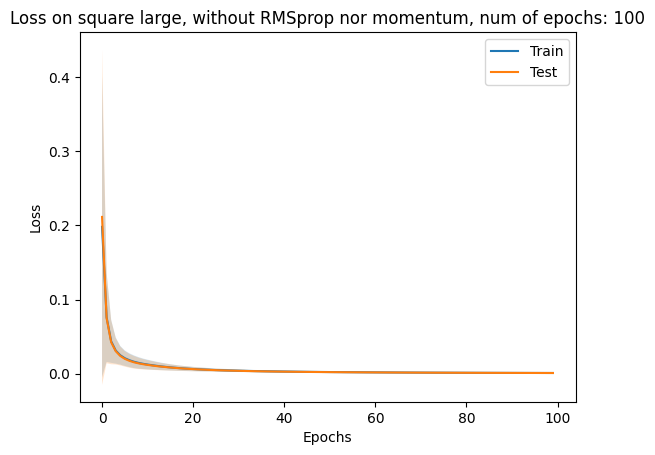

In [44]:
sum_losses = {}
sum_test_losses = {}
mses = []
momentum = 0.9
squred_gradient_decay = 0.9


for run in range(5):
    mlp_steps = networks.MLP(layers, input=steps_large_train_norm[["x"]].T, regularization_alpha=0)


    losses, test_losses = mlp_steps.train(steps_large_train_norm[["x"]].T.to_numpy(), steps_large_train_norm[["y"]].T.to_numpy(), steps_large_test_norm[["x"]].T.to_numpy(), steps_large_test_norm[["y"]].T.to_numpy(),
                         rms_prop=False, momentum=False, squared_gradient_decay=squred_gradient_decay,
                            max_epochs=max_epochs, learning_rate = 0.02, batch_size=32, verbose=False, plot_losses=False, early_stopping=False)
    sum_losses[run] = losses
    sum_test_losses[run] = test_losses
    
    y_hat = mlp_steps.full_forward_pass(steps_large_test_norm[["x"]].T.to_numpy())

    mse = np.mean((steps_large_test["y"] - norm_steps.denorm(y_hat.T, index="y").flatten())**2)
    mses.append(mse)
    
    
sum_losses = pd.DataFrame(sum_losses)
sum_test_losses = pd.DataFrame(sum_test_losses)

print("Mean MSE:  {:.2f}±{:.2f}".format(np.mean(mses), np.std(mses)))

plt.plot(sum_losses.index, sum_losses.mean(axis=1), label="Train")
plt.fill_between(sum_losses.index, sum_losses.mean(axis=1) - sum_losses.std(axis=1), sum_losses.mean(axis=1) + sum_losses.std(axis=1), alpha=0.2)
plt.plot(sum_test_losses.index, sum_test_losses.mean(axis=1), label="Test")
plt.fill_between(sum_test_losses.index, sum_test_losses.mean(axis=1) - sum_test_losses.std(axis=1), sum_test_losses.mean(axis=1) + sum_test_losses.std(axis=1), alpha=0.2)
plt.legend()
plt.xlabel('Epochs')
plt.ylabel('Loss')

plt.title(f'Loss on square large, without RMSprop nor momentum, num of epochs: {max_epochs}')

## steps large 

In [13]:
layers = [
    {"output_dim": 20, "activation": "relu", "init": "he"},
    #{"output_dim": 3, "activation": "relu", "init_method": "he"},
    {"output_dim": 20, "activation": "relu", "init": "he"},

    {"activation": "linear", "init": "normal"}
]



norm_steps = networks.assets.Normalizator(steps_large_train)
steps_large_train_norm = norm_steps(steps_large_train)
steps_large_test_norm = norm_steps(steps_large_test)

mlp_steps = networks.MLP(layers, input=steps_large_train_norm[["x"]].T)


In [14]:
steps_large_train_norm[["x"]].T.to_numpy().shape[1]

10000

In [15]:
max_epochs = 2000


Mean MSE:  103.91±74.29


Text(0.5, 1.0, 'Loss on steps large, no momentum nor rms prop, num of epochs: 2000')

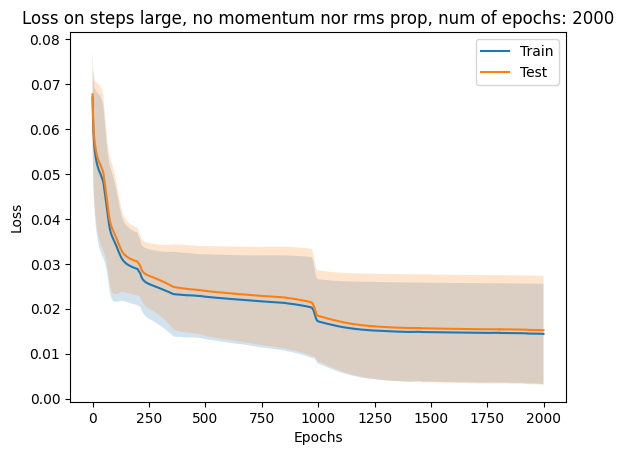

In [24]:
sum_losses = {}
sum_test_losses = {}
mses = []
for run in range(5):
    mlp_steps = networks.MLP(layers, input=steps_large_train_norm[["x"]].T, regularization_alpha=0)


    losses, test_losses = mlp_steps.train(steps_large_train_norm[["x"]].T.to_numpy(), steps_large_train_norm[["y"]].T.to_numpy(), steps_large_test_norm[["x"]].T.to_numpy(), steps_large_test_norm[["y"]].T.to_numpy(),
                            max_epochs=max_epochs, learning_rate = 0.01, batch_size=32, verbose=False, plot_losses=False, early_stopping=False)
    sum_losses[run] = losses
    sum_test_losses[run] = test_losses
    
    y_hat = mlp_steps.full_forward_pass(steps_large_test_norm[["x"]].T.to_numpy())

    mse = np.mean((steps_large_test["y"] - norm_steps.denorm(y_hat.T, index="y").flatten())**2)
    mses.append(mse)
    
    
sum_losses = pd.DataFrame(sum_losses)
sum_test_losses = pd.DataFrame(sum_test_losses)

print("Mean MSE:  {:.2f}±{:.2f}".format(np.mean(mses), np.std(mses)))

plt.plot(sum_losses.index, sum_losses.mean(axis=1), label="Train")
plt.fill_between(sum_losses.index, sum_losses.mean(axis=1) - sum_losses.std(axis=1), sum_losses.mean(axis=1) + sum_losses.std(axis=1), alpha=0.2)
plt.plot(sum_test_losses.index, sum_test_losses.mean(axis=1), label="Test")
plt.fill_between(sum_test_losses.index, sum_test_losses.mean(axis=1) - sum_test_losses.std(axis=1), sum_test_losses.mean(axis=1) + sum_test_losses.std(axis=1), alpha=0.2)
plt.legend()
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title(f'Loss on steps large, no momentum nor rms prop, num of epochs: {max_epochs}')

MSE on test data:  18.427521186294733


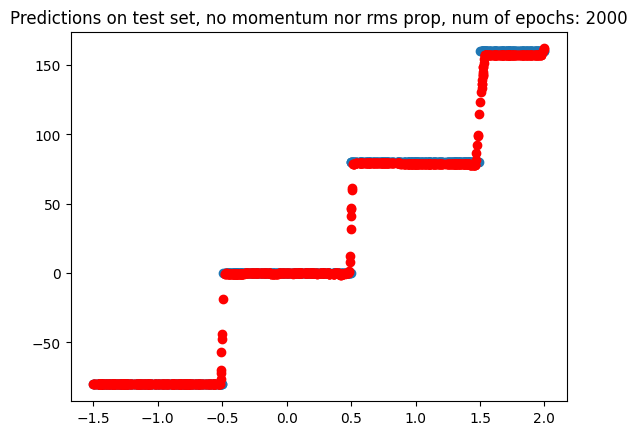

In [28]:
y_hat = mlp_steps.full_forward_pass(steps_large_test_norm[["x"]].T.to_numpy())

plt.scatter(steps_large_test["x"], steps_large_test["y"])
plt.scatter(steps_large_test["x"], norm_steps.denorm(y_hat.T, index="y"), color="red")
plt.title(f"Predictions on test set, no momentum nor rms prop, num of epochs: {max_epochs}")

mse = np.mean((steps_large_test["y"] - norm_steps.denorm(y_hat.T, index="y").flatten())**2)
print("MSE on test data: ", mse)

Mean MSE:  46.95±42.61


Text(0.5, 1.0, 'Loss on steps large, with momentum decay 0.1, num of epochs: 2000')

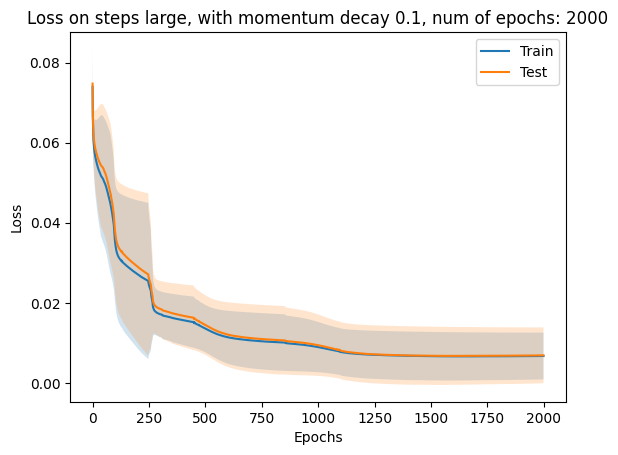

In [23]:
sum_losses = {}
sum_test_losses = {}
mses = []

momentum_decay = 0.1


for run in range(5):
    mlp_steps = networks.MLP(layers, input=steps_large_train_norm[["x"]].T, regularization_alpha=0)


    losses, test_losses = mlp_steps.train(steps_large_train_norm[["x"]].T.to_numpy(), steps_large_train_norm[["y"]].T.to_numpy(), steps_large_test_norm[["x"]].T.to_numpy(), steps_large_test_norm[["y"]].T.to_numpy(),
                            momentum=True, momentum_decay=momentum_decay,
                            max_epochs=max_epochs, learning_rate = 0.01, batch_size=32, verbose=False, plot_losses=False, early_stopping=False)
    sum_losses[run] = losses
    sum_test_losses[run] = test_losses
    
    y_hat = mlp_steps.full_forward_pass(steps_large_test_norm[["x"]].T.to_numpy())

    mse = np.mean((steps_large_test["y"] - norm_steps.denorm(y_hat.T, index="y").flatten())**2)
    mses.append(mse)
    
    
sum_losses = pd.DataFrame(sum_losses)
sum_test_losses = pd.DataFrame(sum_test_losses)

print("Mean MSE:  {:.2f}±{:.2f}".format(np.mean(mses), np.std(mses)))

plt.plot(sum_losses.index, sum_losses.mean(axis=1), label="Train")
plt.fill_between(sum_losses.index, sum_losses.mean(axis=1) - sum_losses.std(axis=1), sum_losses.mean(axis=1) + sum_losses.std(axis=1), alpha=0.2)
plt.plot(sum_test_losses.index, sum_test_losses.mean(axis=1), label="Test")
plt.fill_between(sum_test_losses.index, sum_test_losses.mean(axis=1) - sum_test_losses.std(axis=1), sum_test_losses.mean(axis=1) + sum_test_losses.std(axis=1), alpha=0.2)
plt.legend()
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title(f"Loss on steps large, with momentum decay {momentum_decay}, num of epochs: {max_epochs}")


Epoch: 0, Loss: 0.0706008102761548
Test Loss: 0.07118781191379614
Epoch: 100, Loss: 0.022587913394248767
Test Loss: 0.025033120906778283
Epoch: 200, Loss: 0.01963784910460386
Test Loss: 0.021966063575725885
Epoch: 300, Loss: 0.018524093323201214
Test Loss: 0.020744923178059458
Epoch: 400, Loss: 0.015771718066109292
Test Loss: 0.017545924006325073
Epoch: 500, Loss: 0.010424696390396502
Test Loss: 0.011545171636060506
Epoch: 600, Loss: 0.006433650251874763
Test Loss: 0.006961974383916072
Epoch: 700, Loss: 0.0047703568664159415
Test Loss: 0.004866450979834044
Epoch: 800, Loss: 0.004003801249967418
Test Loss: 0.003806793070467904
Epoch: 900, Loss: 0.0034876896840064617
Test Loss: 0.0031804021629503287
Epoch: 1000, Loss: 0.0031570041248777676
Test Loss: 0.0027714675012191154
Epoch: 1100, Loss: 0.0029594558166985614
Test Loss: 0.002541214622861177
Epoch: 1200, Loss: 0.002849049031798413
Test Loss: 0.002432958701028979
Epoch: 1300, Loss: 0.00280880782626707
Test Loss: 0.0023894248154844168
Ep

Text(0.5, 1.0, 'Training Loss')

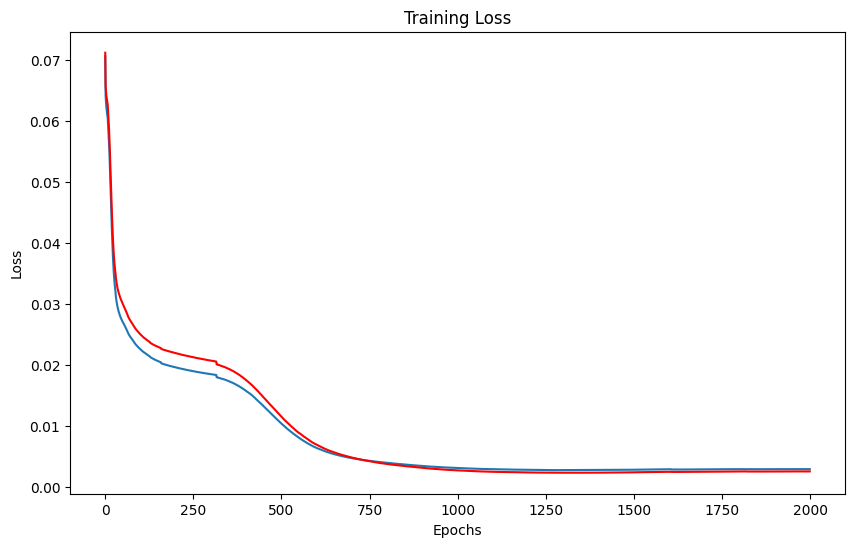

In [29]:
mlp_steps = networks.MLP(layers, input=steps_large_train_norm[["x"]].T)

momentum_decay = 0.1


losses = mlp_steps.train(steps_large_train_norm[["x"]].T.to_numpy(), steps_large_train_norm[["y"]].T.to_numpy(), steps_large_test_norm[["x"]].T.to_numpy(), steps_large_test_norm[["y"]].T.to_numpy(),
                         momentum=True, momentum_decay=momentum_decay,
                         max_epochs=max_epochs, learning_rate = 0.01, batch_size=16)
# losses = mlp_steps.minibatch_train(steps_large_train_norm[["x"]].T.to_numpy(), steps_large_train_norm[["y"]].T.to_numpy(), 0.1, 20000)

#plt.plot(losses[100:])
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training Loss')

MSE on train data:  20.337770610799886


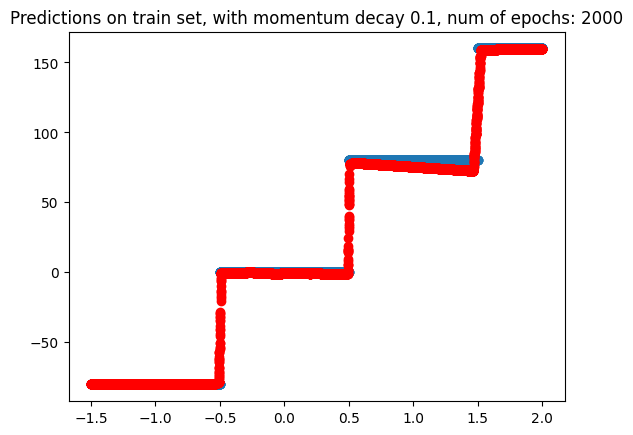

In [30]:
y_hat = mlp_steps.full_forward_pass(steps_large_train_norm[["x"]].T).to_numpy()

plt.scatter(steps_large_train["x"], steps_large_train["y"])
plt.scatter(steps_large_train["x"], norm_steps.denorm(y_hat.T, index="y"), color="red")
plt.title(f"Predictions on train set, with momentum decay {momentum_decay}, num of epochs: {max_epochs}")

mse = np.mean((steps_large_train["y"] - norm_steps.denorm(y_hat.T, index="y").flatten())**2)
print("MSE on train data: ", mse)

MSE on test data:  17.77310533915353


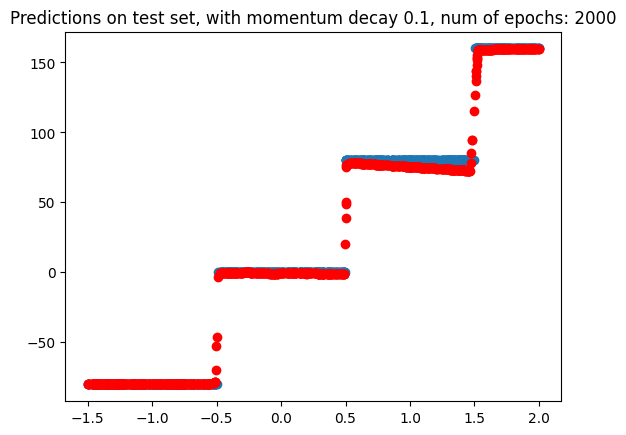

In [31]:
y_hat = mlp_steps.full_forward_pass(steps_large_test_norm[["x"]].T.to_numpy())

plt.scatter(steps_large_test["x"], steps_large_test["y"])
plt.scatter(steps_large_test["x"], norm_steps.denorm(y_hat.T, index="y"), color="red")
plt.title(f"Predictions on test set, with momentum decay {momentum_decay}, num of epochs: {max_epochs}")

mse = np.mean((steps_large_test["y"] - norm_steps.denorm(y_hat.T, index="y").flatten())**2)
print("MSE on test data: ", mse)

Mean MSE:  82.85±52.34


Text(0.5, 1.0, 'Loss on steps large, with RMSprop with squared gradients decay 0.9, num of epochs: 2000')

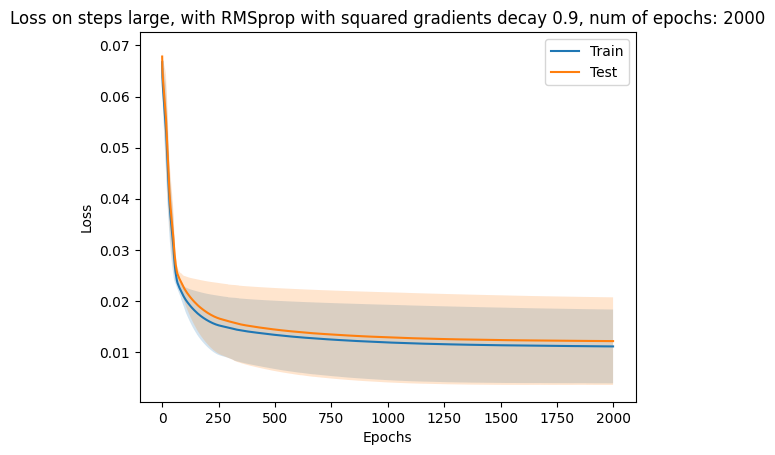

In [25]:
sum_losses = {}
sum_test_losses = {}
mses = []

squred_gradient_decay = 0.9


for run in range(5):
    mlp_steps = networks.MLP(layers, input=steps_large_train_norm[["x"]].T, regularization_alpha=0)


    losses, test_losses = mlp_steps.train(steps_large_train_norm[["x"]].T.to_numpy(), steps_large_train_norm[["y"]].T.to_numpy(), steps_large_test_norm[["x"]].T.to_numpy(), steps_large_test_norm[["y"]].T.to_numpy(),
                         rms_prop=True, squared_gradient_decay=squred_gradient_decay,
                            max_epochs=max_epochs, learning_rate = 0.01, batch_size=32, verbose=False, plot_losses=False, early_stopping=False)
    sum_losses[run] = losses
    sum_test_losses[run] = test_losses
    
    y_hat = mlp_steps.full_forward_pass(steps_large_test_norm[["x"]].T.to_numpy())

    mse = np.mean((steps_large_test["y"] - norm_steps.denorm(y_hat.T, index="y").flatten())**2)
    mses.append(mse)
    
    
sum_losses = pd.DataFrame(sum_losses)
sum_test_losses = pd.DataFrame(sum_test_losses)

print("Mean MSE:  {:.2f}±{:.2f}".format(np.mean(mses), np.std(mses)))

plt.plot(sum_losses.index, sum_losses.mean(axis=1), label="Train")
plt.fill_between(sum_losses.index, sum_losses.mean(axis=1) - sum_losses.std(axis=1), sum_losses.mean(axis=1) + sum_losses.std(axis=1), alpha=0.2)
plt.plot(sum_test_losses.index, sum_test_losses.mean(axis=1), label="Test")
plt.fill_between(sum_test_losses.index, sum_test_losses.mean(axis=1) - sum_test_losses.std(axis=1), sum_test_losses.mean(axis=1) + sum_test_losses.std(axis=1), alpha=0.2)
plt.legend()
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title(f'Loss on steps large, with RMSprop with squared gradients decay {squred_gradient_decay}, num of epochs: {max_epochs}')

Epoch: 0, Loss: 0.06773487405915732
Test Loss: 0.06874564669470633
Epoch: 100, Loss: 0.022806149422785204
Test Loss: 0.02500487276872452
Epoch: 200, Loss: 0.02063288102501065
Test Loss: 0.022981684035887375
Epoch: 300, Loss: 0.019656552243562272
Test Loss: 0.02202422924157896
Epoch: 400, Loss: 0.013638577272588248
Test Loss: 0.015173673960620892
Epoch: 500, Loss: 0.0071708135570018325
Test Loss: 0.0076774923996715295
Epoch: 600, Loss: 0.005173487623795662
Test Loss: 0.005018035329260209
Epoch: 700, Loss: 0.00434718745197684
Test Loss: 0.003960129031056839
Epoch: 800, Loss: 0.0038931221689960586
Test Loss: 0.0034027501918028735
Epoch: 900, Loss: 0.003627361590188079
Test Loss: 0.003099052617602905
Epoch: 1000, Loss: 0.0035292876713119235
Test Loss: 0.002967804620901653
Epoch: 1100, Loss: 0.0034696562578424
Test Loss: 0.0029059736357273367
Epoch: 1200, Loss: 0.0034602726156754884
Test Loss: 0.002904526003741341
Epoch: 1300, Loss: 0.003470179406507492
Test Loss: 0.0029263102741968953
Epoc

Text(0.5, 1.0, 'Training Loss')

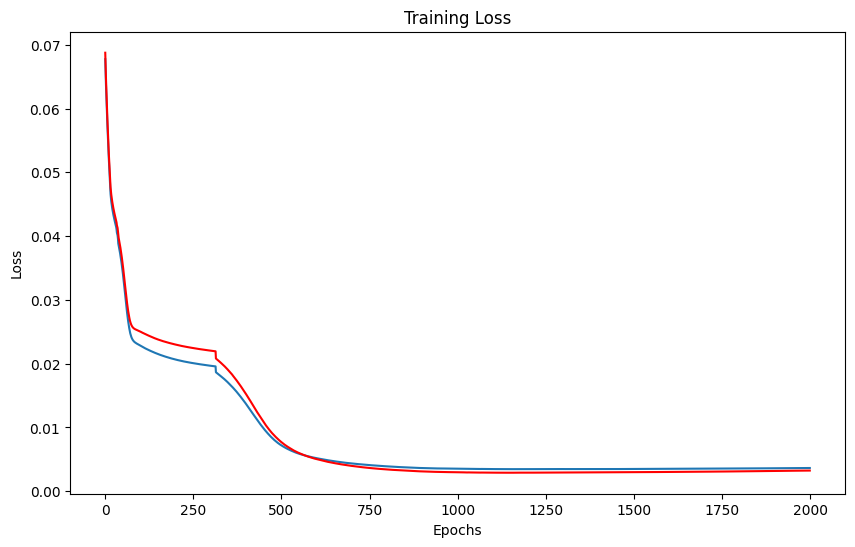

In [32]:
mlp_steps = networks.MLP(layers, input=steps_large_train_norm[["x"]].T)

squred_gradient_decay = 0.9


losses = mlp_steps.train(steps_large_train_norm[["x"]].T.to_numpy(), steps_large_train_norm[["y"]].T.to_numpy(), steps_large_test_norm[["x"]].T.to_numpy(), steps_large_test_norm[["y"]].T.to_numpy(),
                         rms_prop=True, squared_gradient_decay=squred_gradient_decay,
                         max_epochs=max_epochs, learning_rate = 0.01, batch_size=16)
# losses = mlp_steps.minibatch_train(steps_large_train_norm[["x"]].T.to_numpy(), steps_large_train_norm[["y"]].T.to_numpy(), 0.1, 20000)

#plt.plot(losses[100:])
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training Loss')

MSE on test data:  22.091436837374797


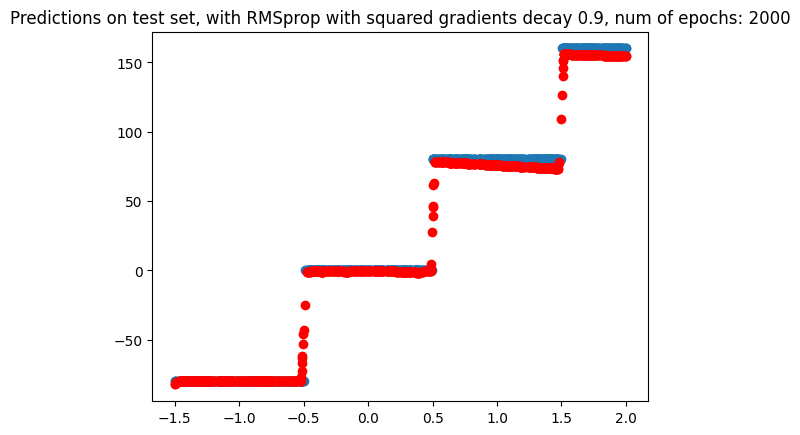

In [33]:
y_hat = mlp_steps.full_forward_pass(steps_large_test_norm[["x"]].T.to_numpy())

plt.scatter(steps_large_test["x"], steps_large_test["y"])
plt.scatter(steps_large_test["x"], norm_steps.denorm(y_hat.T, index="y"), color="red")

plt.title(f"Predictions on test set, with RMSprop with squared gradients decay {squred_gradient_decay}, num of epochs: {max_epochs}")

mse = np.mean((steps_large_test["y"] - norm_steps.denorm(y_hat.T, index="y").flatten())**2)
print("MSE on test data: ", mse)

# Multimodal large

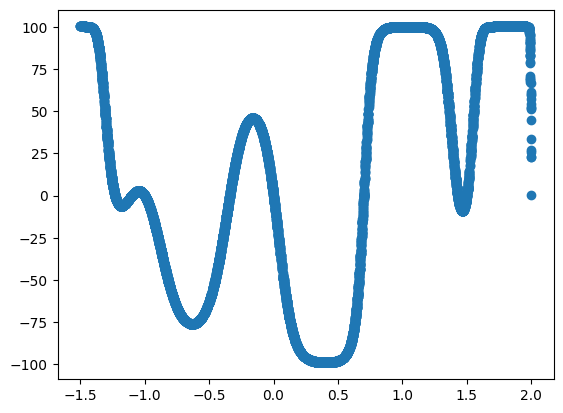

In [26]:

norm_multimodal = networks.assets.Normalizator(multimodal_large_train)

multimodal_large_train_norm = norm_multimodal(multimodal_large_train)
multimodal_large_test_norm = norm_multimodal(multimodal_large_test)

plt.scatter(multimodal_large_train["x"], multimodal_large_train["y"])

In [27]:
multimodal_large_train_norm.std()

x    1.0
y    1.0
dtype: float64

In [ ]:
layers = [
    {"output_dim": 20, "activation": "relu", "init": "he"},
    {"output_dim": 20, "activation": "relu", "init": "he"},
    {"activation": "linear", "init": "normal"}
]

max_epochs = 5000

In [31]:
steps_large_test = multimodal_large_test
steps_large_train = multimodal_large_train
norm_steps = norm_multimodal
steps_large_train_norm = multimodal_large_train_norm
steps_large_test_norm = multimodal_large_test_norm

Mean MSE:  60.17±32.40


Text(0.5, 1.0, 'Loss on multimodal-large, with RMSprop with squared gradients decay 0.9, num of epochs: 2000')

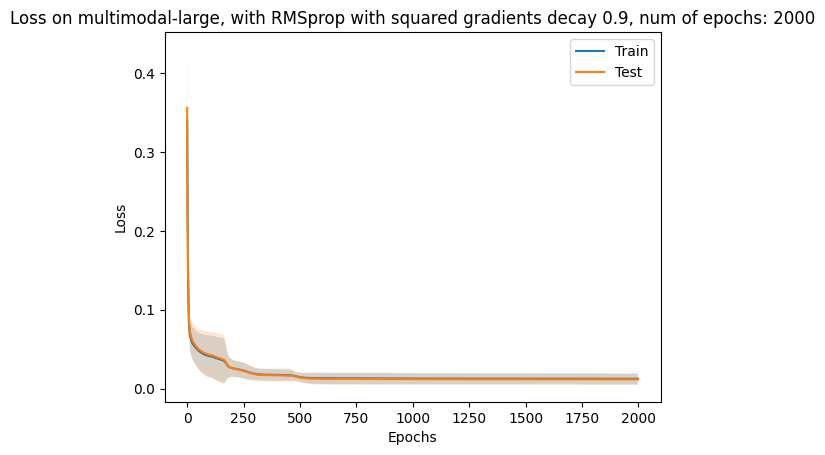

In [32]:
sum_losses = {}
sum_test_losses = {}
mses = []
squred_gradient_decay = 0.9


for run in range(5):
    mlp_steps = networks.MLP(layers, input=steps_large_train_norm[["x"]].T, regularization_alpha=0)


    losses, test_losses = mlp_steps.train(steps_large_train_norm[["x"]].T.to_numpy(), steps_large_train_norm[["y"]].T.to_numpy(), steps_large_test_norm[["x"]].T.to_numpy(), steps_large_test_norm[["y"]].T.to_numpy(),
                         rms_prop=True, momentum=False, squared_gradient_decay=squred_gradient_decay,
                            max_epochs=max_epochs, learning_rate = 0.02, batch_size=32, verbose=False, plot_losses=False, early_stopping=False)
    sum_losses[run] = losses
    sum_test_losses[run] = test_losses
    
    y_hat = mlp_steps.full_forward_pass(steps_large_test_norm[["x"]].T.to_numpy())

    mse = np.mean((steps_large_test["y"] - norm_steps.denorm(y_hat.T, index="y").flatten())**2)
    mses.append(mse)
    
    
sum_losses = pd.DataFrame(sum_losses)
sum_test_losses = pd.DataFrame(sum_test_losses)

print("Mean MSE:  {:.2f}±{:.2f}".format(np.mean(mses), np.std(mses)))

plt.plot(sum_losses.index, sum_losses.mean(axis=1), label="Train")
plt.fill_between(sum_losses.index, sum_losses.mean(axis=1) - sum_losses.std(axis=1), sum_losses.mean(axis=1) + sum_losses.std(axis=1), alpha=0.2)
plt.plot(sum_test_losses.index, sum_test_losses.mean(axis=1), label="Test")
plt.fill_between(sum_test_losses.index, sum_test_losses.mean(axis=1) - sum_test_losses.std(axis=1), sum_test_losses.mean(axis=1) + sum_test_losses.std(axis=1), alpha=0.2)
plt.legend()
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title(f'Loss on multimodal-large, with RMSprop with squared gradients decay {squred_gradient_decay}, num of epochs: {max_epochs}')

Mean MSE:  56.69±48.68


Text(0.5, 1.0, 'Loss on multimodal-large, with momentum, momentum decay 0.05, num of epochs: 2000')

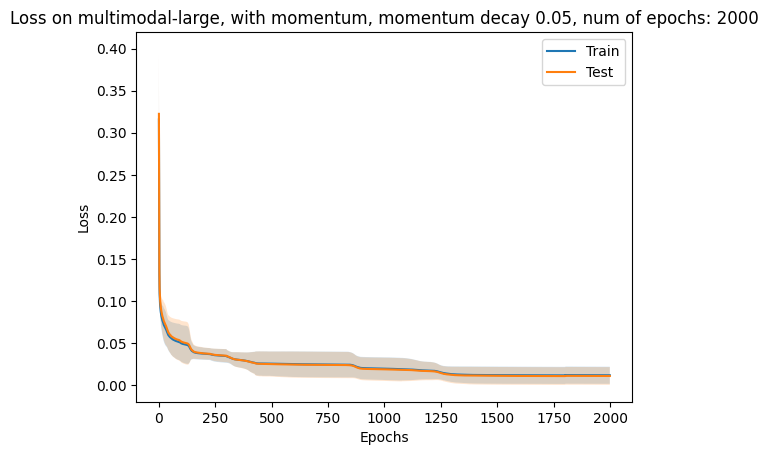

In [33]:
sum_losses = {}
sum_test_losses = {}
mses = []
momentum = 0.05


for run in range(5):
    mlp_steps = networks.MLP(layers, input=steps_large_train_norm[["x"]].T, regularization_alpha=0)


    losses, test_losses = mlp_steps.train(steps_large_train_norm[["x"]].T.to_numpy(), steps_large_train_norm[["y"]].T.to_numpy(), steps_large_test_norm[["x"]].T.to_numpy(), steps_large_test_norm[["y"]].T.to_numpy(),
                         rms_prop=False, momentum=True, momentum_decay=momentum,
                            max_epochs=max_epochs, learning_rate = 0.02, batch_size=32, verbose=False, plot_losses=False, early_stopping=False)
    sum_losses[run] = losses
    sum_test_losses[run] = test_losses
    
    y_hat = mlp_steps.full_forward_pass(steps_large_test_norm[["x"]].T.to_numpy())

    mse = np.mean((steps_large_test["y"] - norm_steps.denorm(y_hat.T, index="y").flatten())**2)
    mses.append(mse)
    
    
sum_losses = pd.DataFrame(sum_losses)
sum_test_losses = pd.DataFrame(sum_test_losses)

print("Mean MSE:  {:.2f}±{:.2f}".format(np.mean(mses), np.std(mses)))

plt.plot(sum_losses.index, sum_losses.mean(axis=1), label="Train")
plt.fill_between(sum_losses.index, sum_losses.mean(axis=1) - sum_losses.std(axis=1), sum_losses.mean(axis=1) + sum_losses.std(axis=1), alpha=0.2)
plt.plot(sum_test_losses.index, sum_test_losses.mean(axis=1), label="Test")
plt.fill_between(sum_test_losses.index, sum_test_losses.mean(axis=1) - sum_test_losses.std(axis=1), sum_test_losses.mean(axis=1) + sum_test_losses.std(axis=1), alpha=0.2)
plt.legend()
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title(f'Loss on multimodal-large, with momentum, momentum decay {momentum}, num of epochs: {max_epochs}')

Mean MSE:  149.97±148.14


Text(0.5, 1.0, 'Loss on multimodal-large, without momentum nor RMSProp, num of epochs: 2000')

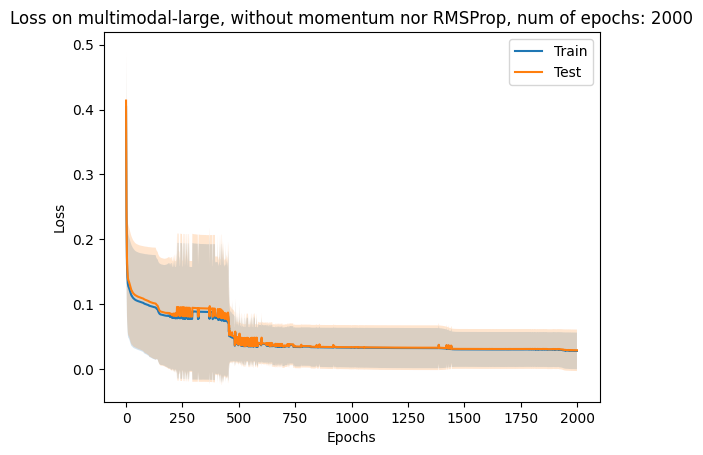

In [34]:
sum_losses = {}
sum_test_losses = {}
mses = []
squred_gradient_decay = 0.9


for run in range(5):
    mlp_steps = networks.MLP(layers, input=steps_large_train_norm[["x"]].T, regularization_alpha=0)


    losses, test_losses = mlp_steps.train(steps_large_train_norm[["x"]].T.to_numpy(), steps_large_train_norm[["y"]].T.to_numpy(), steps_large_test_norm[["x"]].T.to_numpy(), steps_large_test_norm[["y"]].T.to_numpy(),
                         rms_prop=False, momentum=False, squared_gradient_decay=squred_gradient_decay,
                            max_epochs=max_epochs, learning_rate = 0.02, batch_size=32, verbose=False, plot_losses=False, early_stopping=False)
    sum_losses[run] = losses
    sum_test_losses[run] = test_losses
    
    y_hat = mlp_steps.full_forward_pass(steps_large_test_norm[["x"]].T.to_numpy())

    mse = np.mean((steps_large_test["y"] - norm_steps.denorm(y_hat.T, index="y").flatten())**2)
    mses.append(mse)
    
    
sum_losses = pd.DataFrame(sum_losses)
sum_test_losses = pd.DataFrame(sum_test_losses)

print("Mean MSE:  {:.2f}±{:.2f}".format(np.mean(mses), np.std(mses)))

plt.plot(sum_losses.index, sum_losses.mean(axis=1), label="Train")
plt.fill_between(sum_losses.index, sum_losses.mean(axis=1) - sum_losses.std(axis=1), sum_losses.mean(axis=1) + sum_losses.std(axis=1), alpha=0.2)
plt.plot(sum_test_losses.index, sum_test_losses.mean(axis=1), label="Test")
plt.fill_between(sum_test_losses.index, sum_test_losses.mean(axis=1) - sum_test_losses.std(axis=1), sum_test_losses.mean(axis=1) + sum_test_losses.std(axis=1), alpha=0.2)
plt.legend()
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title(f'Loss on multimodal-large, without momentum nor RMSProp, num of epochs: {max_epochs}')

Epoch: 0, Loss: 0.44319655406043557


Epoch: 100, Loss: 0.04631682229796727
Epoch: 200, Loss: 0.01516593698613317
Epoch: 300, Loss: 0.006160799551228184
Epoch: 400, Loss: 0.00516893821441544
Epoch: 500, Loss: 0.005004292729713984
Epoch: 600, Loss: 0.00496789971123553
Epoch: 700, Loss: 0.004937835945093695
Epoch: 800, Loss: 0.004917240913465984
Epoch: 900, Loss: 0.004898262578370005
Epoch: 1000, Loss: 0.004883276879543945
Epoch: 1100, Loss: 0.004873754901873728
Epoch: 1200, Loss: 0.004869096487895415
Epoch: 1300, Loss: 0.0048668467773050035
Epoch: 1400, Loss: 0.004863354835892165
Epoch: 1500, Loss: 0.004860226735536918
Epoch: 1600, Loss: 0.0048583925174615185
Epoch: 1700, Loss: 0.004852908896064882
Epoch: 1800, Loss: 0.004812410090433574
Epoch: 1900, Loss: 0.0048035714388038235
Epoch: 2000, Loss: 0.004795027389989552
Epoch: 2100, Loss: 0.004786833348262101
Epoch: 2200, Loss: 0.004778274913119216
Epoch: 2300, Loss: 0.004619499616152369
Epoch: 2400, Loss: 0.004608349204928734
Epoch: 2500, Loss: 0.004599804531636507
Epoch: 260

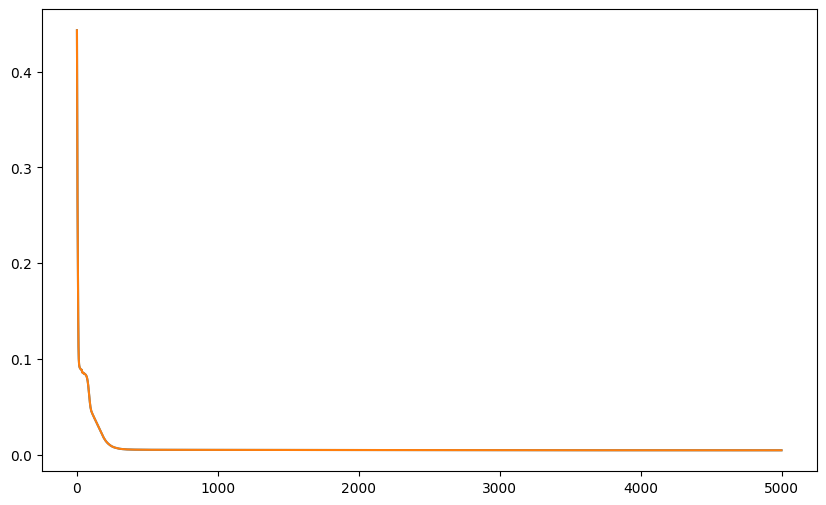

In [19]:
layers = [
    {"output_dim": 20, "activation": "relu", "init": "he"},
    {"output_dim": 20, "activation": "relu", "init": "he"},
    {"activation": "linear", "init": "normal"}
]

max_epochs = 5000

mlp_multimodal = networks.MLP(layers, input=multimodal_large_train_norm[["x"]].T)


losses = mlp_multimodal.train(multimodal_large_train_norm[["x"]].T.to_numpy(), multimodal_large_train_norm[["y"]].T.to_numpy(), multimodal_large_test_norm[["x"]].T.to_numpy(), multimodal_large_test_norm[["y"]].T.to_numpy(), 
                              max_epochs=max_epochs, batch_size=32, early_loss_stop = 1e-8, learning_rate=0.02)

plt.plot(losses)

MSE on test data:  7.122961363479482


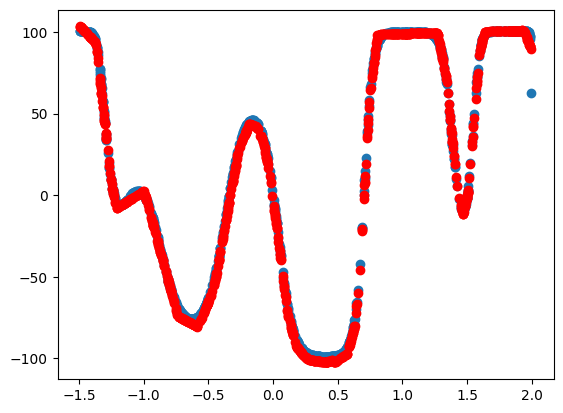

In [22]:
y_hat = mlp_multimodal.full_forward_pass(multimodal_large_test_norm[["x"]].T.to_numpy())

plt.scatter(multimodal_large_test["x"], multimodal_large_test["y"])
plt.scatter(multimodal_large_test["x"], norm_multimodal.denorm(y_hat.T, index="y"), color="red")

plt.title(f"Predictions on test set, no momentum nor rms prop, num of epochs: {max_epochs}")

mse = np.mean((multimodal_large_test["y"] - norm_multimodal.denorm(y_hat.T, index="y").flatten())**2)
print("MSE on test data: ", mse)

Epoch: 0, Loss: 0.4089180897792131
Epoch: 100, Loss: 0.03471946908121935
Epoch: 200, Loss: 0.031136704896501784
Epoch: 300, Loss: 0.030450144087920294
Epoch: 400, Loss: 0.030111236671315236
Epoch: 500, Loss: 0.02989682570450944
Epoch: 600, Loss: 0.029726238968150038
Epoch: 700, Loss: 0.029620047733975752
Epoch: 800, Loss: 0.029529548409480584
Epoch: 900, Loss: 0.02946840359285013
Epoch: 1000, Loss: 0.02942153295362254
Epoch: 1100, Loss: 0.029373173007016317
Epoch: 1200, Loss: 0.02933646806699599
Epoch: 1300, Loss: 0.029302580977257735
Epoch: 1400, Loss: 0.025116254618097723
Epoch: 1500, Loss: 0.014048388932853635
Epoch: 1600, Loss: 0.010462743506155335
Epoch: 1700, Loss: 0.009603129544630183
Epoch: 1800, Loss: 0.0077645821238551075
Epoch: 1900, Loss: 0.0062780521228214805
Epoch: 2000, Loss: 0.0059983914106781396
Epoch: 2100, Loss: 0.005509065907925282
Epoch: 2200, Loss: 0.0052888133358952065
Epoch: 2300, Loss: 0.005072159875989447
Epoch: 2400, Loss: 0.005061055435548584
Epoch: 2500, Lo

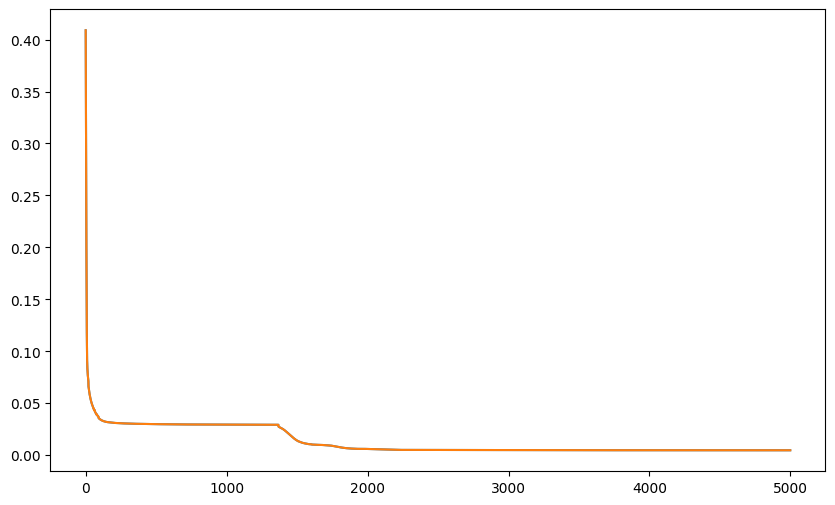

In [20]:

mlp_multimodal = networks.MLP(layers, input=multimodal_large_train_norm[["x"]].T)

momentum_decay = 0.05


losses = mlp_multimodal.train(multimodal_large_train_norm[["x"]].T.to_numpy(), multimodal_large_train_norm[["y"]].T.to_numpy(), max_epochs=max_epochs, batch_size=32, early_loss_stop = 1e-8, learning_rate=0.02, momentum=True, momentum_decay=momentum_decay)

plt.plot(losses)

MSE on test data:  22.772569244249944


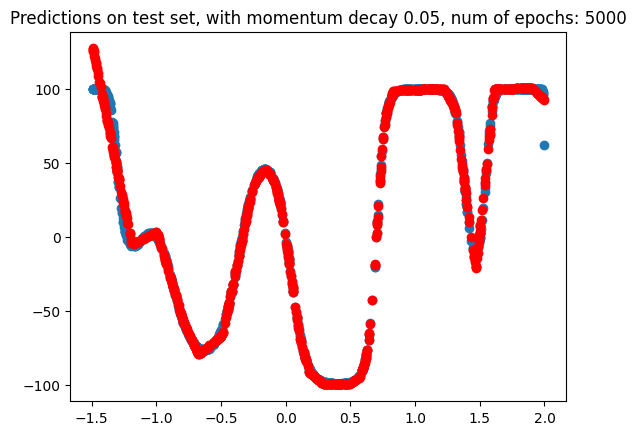

In [21]:
y_hat = mlp_multimodal.full_forward_pass(multimodal_large_test_norm[["x"]].T.to_numpy())

plt.scatter(multimodal_large_test["x"], multimodal_large_test["y"])
plt.scatter(multimodal_large_test["x"], norm_multimodal.denorm(y_hat.T, index="y"), color="red")

plt.title(f"Predictions on test set, with momentum decay {momentum_decay}, num of epochs: {max_epochs}")

mse = np.mean((multimodal_large_test["y"] - norm_multimodal.denorm(y_hat.T, index="y").flatten())**2)
print("MSE on test data: ", mse)

Epoch: 0, Loss: 0.3709478239703055
Epoch: 100, Loss: 0.08667110414885178
Epoch: 200, Loss: 0.08597032704529074
Epoch: 300, Loss: 0.08548831758318827
Epoch: 400, Loss: 0.0851350140021543
Epoch: 500, Loss: 0.08487065781386655
Epoch: 600, Loss: 0.08466061407957957
Epoch: 700, Loss: 0.0844832941803352
Epoch: 800, Loss: 0.032366073083208255
Epoch: 900, Loss: 0.029057333081598035
Epoch: 1000, Loss: 0.02643241939283142
Epoch: 1100, Loss: 0.01372315716247814
Epoch: 1200, Loss: 0.009933540573942917
Epoch: 1300, Loss: 0.009475475878632551
Epoch: 1400, Loss: 0.0089960657542463
Epoch: 1500, Loss: 0.008692123132849262
Epoch: 1600, Loss: 0.008454433041670704
Epoch: 1700, Loss: 0.008392931253815702
Epoch: 1800, Loss: 0.008225539506142772
Epoch: 1900, Loss: 0.007626497866281781


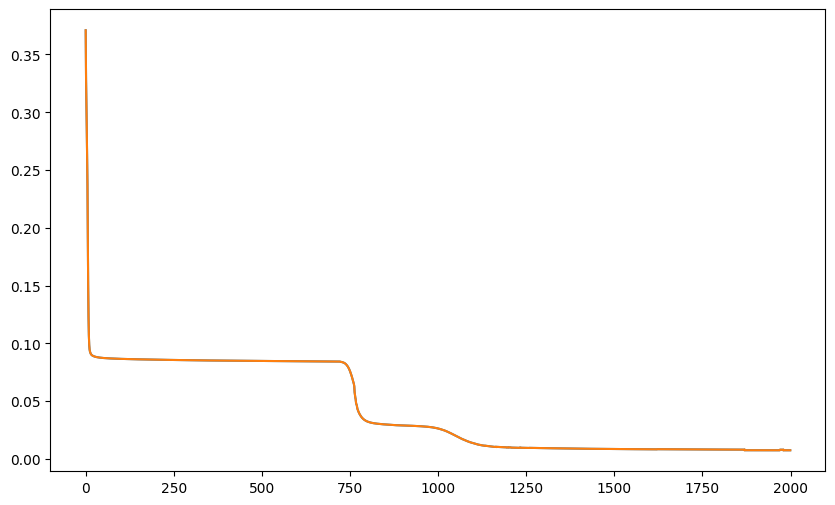

In [22]:

mlp_multimodal = networks.MLP(layers, input=multimodal_large_train_norm[["x"]].T)

squred_gradient_decay = 0.9


losses = mlp_multimodal.train(multimodal_large_train_norm[["x"]].T.to_numpy(), multimodal_large_train_norm[["y"]].T.to_numpy(), max_epochs=2000, batch_size=32, early_loss_stop = 1e-8, learning_rate=0.02, rms_prop=True, squared_gradient_decay=squred_gradient_decay)

plt.plot(losses)

MSE on test data:  33.69232730285283


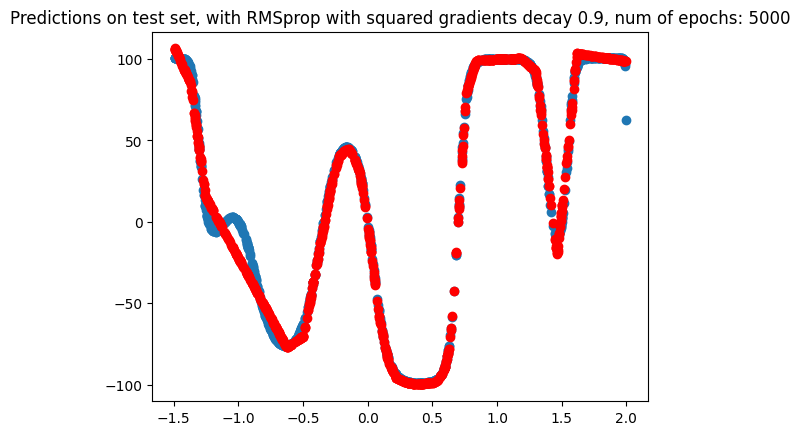

In [23]:
y_hat = mlp_multimodal.full_forward_pass(multimodal_large_test_norm[["x"]].T.to_numpy())

plt.scatter(multimodal_large_test["x"], multimodal_large_test["y"])
plt.scatter(multimodal_large_test["x"], norm_multimodal.denorm(y_hat.T, index="y"), color="red")

plt.title(f"Predictions on test set, with RMSprop with squared gradients decay {squred_gradient_decay}, num of epochs: {max_epochs}")

mse = np.mean((multimodal_large_test["y"] - norm_multimodal.denorm(y_hat.T, index="y").flatten())**2)
print("MSE on test data: ", mse)